In [3]:
import pandas as pd
import geopandas as gpd
import json 
import plotly.express as px
import plotly.figure_factory as ff
from datetime import datetime

# England Crime Heatmap
The aim of this notebook is to visualise the frequency of different types of crime in England and other areas of the UK. We hope to be able to spot areas of low and high crime with ease. 

We will use different chart types to visualise the data. This will help us become familiar with these plots and see the benefits and drawbacks of each. We will create a crime heat map using the following chart types: 
- Choropleth, splitting the UK by Electoral Ward Boundaries. 
- Scatter plot of crime on a map 
- Hex Bin plot (split UK regions into equal sized hexagon boundaries and calculate crime rate per hexagon). 

**Please note** - All plotly figures are displayed as static png images. The interactive plotly images had very large file sizes which made the notebook too large to upload to github. If you wish to display them as interactive plots, simply change *fig.show(renderer = 'png')* to *fig.show()*

## Load and Check Crime Data
The data was downloaded from the [UK Police Website](https://data.police.uk/data/). We took 3 years of data, from July 2022 (the latest data available) back to August 2019. It came split into many separate csv files. A separate file was provided per month of data and per police force (each month had a separate csv for each police force). A script was created (available in the github repo) that combined all these files into a single csv with all the data. 

We will load this csv and do a quick check to ensure the data was combined together correctly. 

In [4]:
crime_data = pd.read_csv('all_crime_data.csv')
crime_data.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
0,c7000c41002f19263d4adec66b911f1c3f5e7eeb1302a3...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.570572,53.607792,On or near Park/Open Space,E01007418,Barnsley 016A,Other theft,Status update unavailable,NaN
1,b8bc1b6cf423a9431734982fffb11f803cf82140702cc7...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.670108,53.553629,On or near Huddersfield Road,E01007426,Barnsley 027D,Robbery,Investigation complete; no suspect identified,NaN
2,8c69cefea36edafe5fa3f992ccc31d3cfd0c9af9a81429...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.879031,53.943807,On or near Cross End Fold,E01010646,Bradford 001A,Bicycle theft,Investigation complete; no suspect identified,NaN
3,7236a8fb307214df61ca7a9b93bd309c0524f9bee58d89...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.882746,53.933807,On or near Cocking Lane,E01010646,Bradford 001A,Burglary,Investigation complete; no suspect identified,NaN
4,92803cebdfde14ad870899c45c6bee398331f33a053bf1...,2020-01,West Yorkshire Police,West Yorkshire Police,-1.881467,53.944510,On or near Kilners Croft,E01010646,Bradford 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN


Each row of the data is a crime that was reported. The key information we are interested in is: 
- **Crime type** -> Category of crime e.g. 'anti-social behaviour' 
- **Month** -> Month the crime was reported
- **Longitude** and **Latitude** -> Approximate location crime took place. 


In [5]:
crime_data.describe(include = 'all')

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
count,14399993,18916688,18916688,18916688,1.857235e+07,1.857235e+07,18916688,18086905,18086905,18916688,14100678,0.0
unique,13956127,36,44,44,NaN,NaN,270139,33902,33902,14,16,NaN
top,490b595dc6eb4b0a3e1f8d7fa53d2be5460d146d8f133a...,2020-08,Metropolitan Police Service,Metropolitan Police Service,NaN,NaN,On or near Supermarket,E01033595,Westminster 013E,Violence and sexual offences,Investigation complete; no suspect identified,NaN
freq,69,579773,3349818,3349818,NaN,NaN,555805,22728,22728,6023857,5495700,NaN
mean,NaN,NaN,NaN,NaN,-1.348145e+00,5.241973e+01,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,1.487647e+00,1.181388e+00,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,-8.148313e+00,4.989215e+01,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,-2.117300e+00,5.149653e+01,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,-1.283353e+00,5.213441e+01,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,-1.728390e-01,5.339429e+01,NaN,NaN,NaN,NaN,NaN,NaN


A quick visual check of the above summary confirms that both 'Crime type' and 'Month' have no missing values. We will now check if latitude and longitude have missing values.   

In [6]:
location_data = crime_data[['Latitude', 'Longitude', 'Location']]
# Filter on rows with missing values in 'Latitude', 'Longitude' or 'Location'
location_missing = location_data[location_data.isna().any(axis=1)]
location_missing.value_counts(dropna = False)

Latitude  Longitude  Location   
NaN       NaN        No Location    344341
dtype: int64

From the above value count, we can see that both latitude and longitude are always missing together (i.e. we don't have just a latitude or just a longitude) and when this occurs, the location description is 'No location'. This makes sense. We can see that 344,341 crimes are missing location data. We will now calculate what fraction of all crimes this is. This will help us understand the impact of simply dropping these rows.   

In [7]:
total_crimes = crime_data.shape[0]
perc_missing_location = 344341 / total_crimes

print(f"344,341 crimes missing location data out of {total_crimes:,} total crimes -> {perc_missing_location:.2%}")

344,341 crimes missing location data out of 18,916,688 total crimes -> 1.82%


We can see the crimes missing location data only account for 1.82% of the data, so we are happy to simply drop these rows. In this case, we won't need to actually drop them, they will be dropped later when we match location data to geojson polygons.

As a final check, we will print out the unique values in the 'Month', 'Crime type' and 'Reported by' columns to make sure everything is as we expect and that all of the downloaded data has been combined into the single csv.   

In [8]:
headers = ['Month', 'Crime type', 'Reported by']

for col in headers:
    print(crime_data[col].unique())

['2020-01' '2020-06' '2020-08' '2020-09' '2020-07' '2021-09' '2021-07'
 '2021-01' '2021-06' '2021-08' '2019-11' '2021-12' '2022-03' '2022-04'
 '2019-10' '2022-05' '2022-02' '2020-12' '2020-05' '2020-02' '2020-03'
 '2020-04' '2019-09' '2021-03' '2021-04' '2019-08' '2021-05' '2021-02'
 '2021-11' '2022-07' '2019-12' '2022-01' '2022-06' '2021-10' '2020-10'
 '2020-11']
['Other theft' 'Robbery' 'Bicycle theft' 'Burglary'
 'Criminal damage and arson' 'Violence and sexual offences'
 'Anti-social behaviour' 'Vehicle crime' 'Drugs' 'Shoplifting'
 'Possession of weapons' 'Other crime' 'Public order'
 'Theft from the person']
['West Yorkshire Police' 'Humberside Police' 'Hertfordshire Constabulary'
 'Gloucestershire Constabulary' 'Cleveland Police' 'West Mercia Police'
 'North Yorkshire Police' 'Devon & Cornwall Police' 'Essex Police'
 'Durham Constabulary' 'Metropolitan Police Service'
 'City of London Police' 'Kent Police' 'West Midlands Police'
 'Cambridgeshire Constabulary' 'Staffordshire Poli

Based on the above, each column has the data we expect. All years of data appear to be present and all police forces have been included in the data. 

Finally, we will create a new column that categorises the crimes according to the whether the crime was committed in the last year, in the year before that or in the year before that. To be clear, we have defined the date ranges for each category below: 

|Date Range|Time Period Category|
|---|---|
|Aug-2021 to July-2022|last year|
|Aug-2020 to July-2021|2 years ago|
|Aug-2019 to July-2020|3 years ago|

We will use these categories to filter the data according to how recent the data is, which should help show trends over time. 



In [9]:
# Convert Month to datetime format 
crime_data.Month = pd.to_datetime(crime_data.Month, format = '%Y-%m')

# Show converted months data
crime_data.Month.unique()

array(['2020-01-01T00:00:00.000000000', '2020-06-01T00:00:00.000000000',
       '2020-08-01T00:00:00.000000000', '2020-09-01T00:00:00.000000000',
       '2020-07-01T00:00:00.000000000', '2021-09-01T00:00:00.000000000',
       '2021-07-01T00:00:00.000000000', '2021-01-01T00:00:00.000000000',
       '2021-06-01T00:00:00.000000000', '2021-08-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2021-12-01T00:00:00.000000000',
       '2022-03-01T00:00:00.000000000', '2022-04-01T00:00:00.000000000',
       '2019-10-01T00:00:00.000000000', '2022-05-01T00:00:00.000000000',
       '2022-02-01T00:00:00.000000000', '2020-12-01T00:00:00.000000000',
       '2020-05-01T00:00:00.000000000', '2020-02-01T00:00:00.000000000',
       '2020-03-01T00:00:00.000000000', '2020-04-01T00:00:00.000000000',
       '2019-09-01T00:00:00.000000000', '2021-03-01T00:00:00.000000000',
       '2021-04-01T00:00:00.000000000', '2019-08-01T00:00:00.000000000',
       '2021-05-01T00:00:00.000000000', '2021-02-01

In [10]:
# define date range bins 
bins = [datetime(2019, 8, 1), datetime(2020, 7, 1),
        datetime(2021, 7, 1), datetime(2022, 7, 1)]
# Define category labels per bin interval
labels = ['3 years ago', '2 years ago', 'last year']
# Create time_period variable
crime_data['time_period'] = pd.cut(crime_data.Month, bins = bins, 
                                   labels = labels, right = True, 
                                   include_lowest = True)

time_period_counts = crime_data[['Month', 'time_period']].value_counts()
time_period_counts

Month       time_period
2020-08-01  2 years ago    579773
2020-07-01  3 years ago    575339
2020-05-01  3 years ago    574394
2021-07-01  2 years ago    566234
2021-06-01  2 years ago    561277
2020-06-01  3 years ago    553950
2022-05-01  last year      551406
2019-08-01  3 years ago    551248
2022-07-01  last year      551161
2022-03-01  last year      549477
2020-10-01  2 years ago    546033
2019-10-01  3 years ago    545048
2020-09-01  2 years ago    544549
2021-05-01  2 years ago    541667
2021-10-01  last year      540127
2021-03-01  2 years ago    537133
2021-09-01  last year      530494
2021-08-01  last year      530459
2020-04-01  3 years ago    530200
2022-06-01  last year      529153
2021-04-01  2 years ago    525908
2022-04-01  last year      521492
2019-09-01  3 years ago    520556
2021-11-01  last year      520202
2020-01-01  3 years ago    515869
2019-11-01  3 years ago    514874
2020-11-01  2 years ago    513301
2020-03-01  3 years ago    496444
2022-01-01  last year   

## Crime Heatmap - Choropleth
First, we will use a Choropleth to visualise the crime data. 

### Load UK Electoral Wards Geojson
For our Choropleth plot, we will split the UK by electoral ward boundaries and will calculate the crime rate per electoral ward. The electoral ward boundary data was sourced from the [Office for National Statistics](https://geoportal.statistics.gov.uk/search?q=wards) website and came in geojson format. We chose to use electoral ward boundaries because they provided the most granular boundary data (i.e. generally splits UK into smallest boundaries) that was readily available. The granularity should help provide relatively high accuracy in separating high crime and low crime areas. Ideally, we wanted to use UK Post Code Boundary data, but we could not find this data as a free resource online. 

Below we load and visualise our UK Electoral Ward geojson. 

In [11]:
geojson = gpd.read_file('Wards.geojson')

<AxesSubplot: >

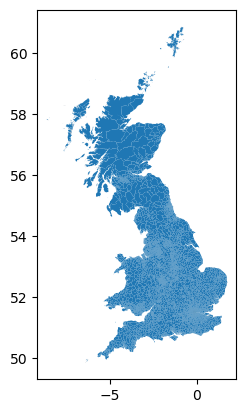

In [12]:
geojson.plot()

In [13]:
geojson.head()

,OBJECTID,WD21CD,WD21NM,WD21NMW,BNG_E,BNG_N,LONG,LAT,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,1,E05000026,Abbey,,544433,184376,0.081276,51.539799,{FB5AFCE3-BCC7-48C0-BA4B-25A1BE545316},0.092963,0.000162,"MULTIPOLYGON (((0.06877 51.53621, 0.06796 51.5..."
1,2,E05000027,Alibon,,549247,185196,0.150987,51.545898,{81870C0A-D87A-4337-8216-A9BA21A7D792},0.079442,0.000176,"MULTIPOLYGON (((0.15638 51.55102, 0.15649 51.5..."
2,3,E05000028,Becontree,,546860,185870,0.116869,51.552601,{015B4C1A-431F-4D3B-8F44-661ADDE997AA},0.074293,0.000167,"MULTIPOLYGON (((0.12716 51.55561, 0.12494 51.5..."
3,4,E05000029,Chadwell Heath,,548266,189340,0.138596,51.583401,{361B4FCB-28B5-4311-B123-F6DFA3A0458F},0.107611,0.000439,"MULTIPOLYGON (((0.14821 51.59897, 0.14765 51.5..."
4,5,E05000030,Eastbrook,,550775,186271,0.173467,51.555199,{1967C5B5-31C1-4CD6-B85A-002A26067F6C},0.104748,0.000447,"MULTIPOLYGON (((0.18515 51.56478, 0.18399 51.5..."


The column 'WD21CD' provides a string description of an area e.g. 'the grove'. We will use this data in our plot. As such, we will rename the column. We also renamed the Latitude, Longitude and unique key (OBJECTID) columns. 

In [14]:
geojson.rename(columns = {'WD21NM':'area_desc', 'LONG': 'Longitude', 
                          'LAT': 'Latitude', 'OBJECTID': 'id'},
                       inplace = True)
geojson.head()

,id,WD21CD,area_desc,WD21NMW,BNG_E,BNG_N,Longitude,Latitude,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,1,E05000026,Abbey,,544433,184376,0.081276,51.539799,{FB5AFCE3-BCC7-48C0-BA4B-25A1BE545316},0.092963,0.000162,"MULTIPOLYGON (((0.06877 51.53621, 0.06796 51.5..."
1,2,E05000027,Alibon,,549247,185196,0.150987,51.545898,{81870C0A-D87A-4337-8216-A9BA21A7D792},0.079442,0.000176,"MULTIPOLYGON (((0.15638 51.55102, 0.15649 51.5..."
2,3,E05000028,Becontree,,546860,185870,0.116869,51.552601,{015B4C1A-431F-4D3B-8F44-661ADDE997AA},0.074293,0.000167,"MULTIPOLYGON (((0.12716 51.55561, 0.12494 51.5..."
3,4,E05000029,Chadwell Heath,,548266,189340,0.138596,51.583401,{361B4FCB-28B5-4311-B123-F6DFA3A0458F},0.107611,0.000439,"MULTIPOLYGON (((0.14821 51.59897, 0.14765 51.5..."
4,5,E05000030,Eastbrook,,550775,186271,0.173467,51.555199,{1967C5B5-31C1-4CD6-B85A-002A26067F6C},0.104748,0.000447,"MULTIPOLYGON (((0.18515 51.56478, 0.18399 51.5..."


### Match Crimes to Geojson Electoral Wards
Now we need to categorise each crime according to the electoral ward that it was reported in. We will use the Geopandas library for this. First, we need to convert the crime data into a geopandas dataframe. We will use the *gpd.points_from_xy* function to convert the latitude and longitude coordinates into the same X Y geometric coordinates as the geojson.

In [15]:
gpd_crime_data = gpd.GeoDataFrame(crime_data, 
                                  geometry = gpd.points_from_xy(
                                      crime_data.Longitude,
                                      crime_data.Latitude, 
                                      crs = ('wgs84')
                                  )
                                 )

In [16]:
gpd_crime_data.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,time_period,geometry
0,c7000c41002f19263d4adec66b911f1c3f5e7eeb1302a3...,2020-01-01,West Yorkshire Police,West Yorkshire Police,-1.570572,53.607792,On or near Park/Open Space,E01007418,Barnsley 016A,Other theft,Status update unavailable,NaN,3 years ago,POINT (-1.57057 53.60779)
1,b8bc1b6cf423a9431734982fffb11f803cf82140702cc7...,2020-01-01,West Yorkshire Police,West Yorkshire Police,-1.670108,53.553629,On or near Huddersfield Road,E01007426,Barnsley 027D,Robbery,Investigation complete; no suspect identified,NaN,3 years ago,POINT (-1.67011 53.55363)
2,8c69cefea36edafe5fa3f992ccc31d3cfd0c9af9a81429...,2020-01-01,West Yorkshire Police,West Yorkshire Police,-1.879031,53.943807,On or near Cross End Fold,E01010646,Bradford 001A,Bicycle theft,Investigation complete; no suspect identified,NaN,3 years ago,POINT (-1.87903 53.94381)
3,7236a8fb307214df61ca7a9b93bd309c0524f9bee58d89...,2020-01-01,West Yorkshire Police,West Yorkshire Police,-1.882746,53.933807,On or near Cocking Lane,E01010646,Bradford 001A,Burglary,Investigation complete; no suspect identified,NaN,3 years ago,POINT (-1.88275 53.93381)
4,92803cebdfde14ad870899c45c6bee398331f33a053bf1...,2020-01-01,West Yorkshire Police,West Yorkshire Police,-1.881467,53.944510,On or near Kilners Croft,E01010646,Bradford 001A,Criminal damage and arson,Investigation complete; no suspect identified,NaN,3 years ago,POINT (-1.88147 53.94451)


Now we will match each reported crime's location (latitude and longitude) to the electoral ward it was reported in using the *sjoin()* function. This will join the geojson and gpd_crime_data together into a single dataset:

In [17]:
crimes_per_area = gpd.sjoin(gpd_crime_data, geojson, how = 'inner',
                            predicate = 'within')
crimes_per_area.head()

,Crime ID,Month,Reported by,Falls within,Longitude_left,Latitude_left,Location,LSOA code,LSOA name,Crime type,...,WD21CD,area_desc,WD21NMW,BNG_E,BNG_N,Longitude_right,Latitude_right,GlobalID,SHAPE_Length,SHAPE_Area
0,c7000c41002f19263d4adec66b911f1c3f5e7eeb1302a3...,2020-01-01,West Yorkshire Police,West Yorkshire Police,-1.570572,53.607792,On or near Park/Open Space,E01007418,Barnsley 016A,Other theft,...,E05000989,Penistone East,,430225,403069,-1.54557,53.523399,{46F58057-275D-423E-9820-4C5BFFDE2CC1},0.846486,0.011988
275973,NaN,2020-01-01,South Yorkshire Police,South Yorkshire Police,-1.580296,53.596510,On or near Jebb Lane,E01007418,Barnsley 016A,Anti-social behaviour,...,E05000989,Penistone East,,430225,403069,-1.54557,53.523399,{46F58057-275D-423E-9820-4C5BFFDE2CC1},0.846486,0.011988
275974,NaN,2020-01-01,South Yorkshire Police,South Yorkshire Police,-1.572224,53.568366,On or near Hill Top,E01007418,Barnsley 016A,Anti-social behaviour,...,E05000989,Penistone East,,430225,403069,-1.54557,53.523399,{46F58057-275D-423E-9820-4C5BFFDE2CC1},0.846486,0.011988
275975,131a33be1e3eca364fce6f0b39b695f9e394deb0fd20dc...,2020-01-01,South Yorkshire Police,South Yorkshire Police,-1.587889,53.589454,On or near Church Lane,E01007418,Barnsley 016A,Burglary,...,E05000989,Penistone East,,430225,403069,-1.54557,53.523399,{46F58057-275D-423E-9820-4C5BFFDE2CC1},0.846486,0.011988
275976,f822684e2576e654d739b60d88a78707b35d84e40fcf2c...,2020-01-01,South Yorkshire Police,South Yorkshire Police,-1.572854,53.565825,On or near Oak Leigh,E01007418,Barnsley 016A,Burglary,...,E05000989,Penistone East,,430225,403069,-1.54557,53.523399,{46F58057-275D-423E-9820-4C5BFFDE2CC1},0.846486,0.011988


### Aggregate Crime Data
We will now create the data for plotting. We want to plot the count of crimes in each electoral ward area. We want to be able to see the count of all crimes per area. We also want to view the counts for individual crime types. We also want the data split by the 'time_period' variable so we can select different time periods to view.

Below we use groupby to get the count of crimes per time period per crime type per area. Note that the 'id' column (originally from the geojson) defines a unique id for each electoral ward boundary i.e. we use it to define each area: 

In [18]:
# define columns to group by ('id' is the geojson area id).
cols = ['time_period', 'Crime type', 'id']
crimes_agg = crimes_per_area.groupby(cols, as_index = False)['Location'].count()
crimes_agg.head()

,time_period,Crime type,id,Location
0,3 years ago,Anti-social behaviour,1,875
1,3 years ago,Anti-social behaviour,2,297
2,3 years ago,Anti-social behaviour,3,370
3,3 years ago,Anti-social behaviour,4,399
4,3 years ago,Anti-social behaviour,5,332


We will now calculate the aggregation for all crime data i.e. will get count of crimes per time period per area: 

In [19]:
# define columns to group by ('id' is the geojson area id)
cols = ['time_period', 'id']
total_crimes_agg = crimes_per_area.groupby(cols, as_index = False)['Location'].count()
total_crimes_agg.head()

,time_period,id,Location
0,3 years ago,1,3830
1,3 years ago,2,1112
2,3 years ago,3,1340
3,3 years ago,4,1316
4,3 years ago,5,1062


Now we will combine the 'all crime' aggregation data with the 'per crime type' aggregation data: 

In [20]:
# Add new column 'Crime type' that contains the string 'All Crimes' so it 
# has the same number of columns as crime_agg
total_crimes_agg.insert(1,'Crime type', 'All Crimes')
total_crimes_agg.head()

,time_period,Crime type,id,Location
0,3 years ago,All Crimes,1,3830
1,3 years ago,All Crimes,2,1112
2,3 years ago,All Crimes,3,1340
3,3 years ago,All Crimes,4,1316
4,3 years ago,All Crimes,5,1062


In [21]:
crimes_agg = pd.concat([crimes_agg, total_crimes_agg], 
                       ignore_index = True)

The column containing the count of crimes is called 'Location' (because that's the column we counted in the groupbys). We will rename it to crime_count. 

In [22]:
crimes_agg.rename(columns = {'Location':'crime_count'}, 
                  inplace = True)

### Enhance Plotting Data
We want to add the following data to enhance our choropleth plot: 
- **area_desc** - This is a short description of each electoral ward e.g. 'tulse hill'. We will use it as pop up information when you hover the cursor over the different areas on the plot. The 'area_desc' is in the geojson. 
- **area_km2** - This is the area enclosed by the electoral ward, measured in km2. The electoral wards range in size from very small areas to quite large ones. The larger areas will naturally capture more crimes. This will distort our data, since what we are really interested in is crime per kilometer squared i.e. the number of crimes expected per equal size chunk of any electoral ward. 

Below, we merge the crimes_agg data with the geojson to add the 'area_desc': 

In [23]:
crimes_agg = pd.merge(left=crimes_agg, 
                      right=geojson[['id', 'area_desc']],
                      left_on='id',
                      right_on='id',
                      how='left')

crimes_agg

,time_period,Crime type,id,crime_count,area_desc
0,3 years ago,Anti-social behaviour,1,875,Abbey
1,3 years ago,Anti-social behaviour,2,297,Alibon
2,3 years ago,Anti-social behaviour,3,370,Becontree
3,3 years ago,Anti-social behaviour,4,399,Chadwell Heath
4,3 years ago,Anti-social behaviour,5,332,Eastbrook
...,...,...,...,...,...
362290,last year,All Crimes,8228,180,Seven Sisters
362291,last year,All Crimes,8229,384,Tai-bach
362292,last year,All Crimes,8230,191,Broughton South
362293,last year,All Crimes,8231,62,Penally


We will now calculate the area_km2 for each polygon in the geojson. First, we need to project the geometric coordinates we are using in the geojson to an equal area projection:

<AxesSubplot: >

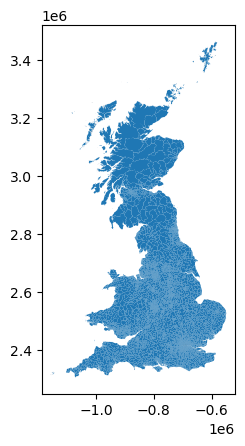

In [24]:
geojson_proj = geojson.to_crs('ESRI:102013')
geojson_proj.plot()

You can see that after projecting, we get a more familiar looking shape to the UK. We will now calculate the polygon areas and merge this data with our crime_aggs data (note we divide the area by 1000,000 to convert it from m<sup>2</sup> to km<sup>2</sup>): 

In [25]:
# Calculate polygon areas in km2
geojson_proj['area_km2'] = geojson_proj.area / 1000000

In [26]:
crimes_agg = pd.merge(left=crimes_agg, 
                      right=geojson_proj[['id', 'area_km2']],
                      left_on='id',
                      right_on='id',
                      how='left')

crimes_agg

,time_period,Crime type,id,crime_count,area_desc,area_km2
0,3 years ago,Anti-social behaviour,1,875,Abbey,1.250646
1,3 years ago,Anti-social behaviour,2,297,Alibon,1.355747
2,3 years ago,Anti-social behaviour,3,370,Becontree,1.291850
3,3 years ago,Anti-social behaviour,4,399,Chadwell Heath,3.387126
4,3 years ago,Anti-social behaviour,5,332,Eastbrook,3.449454
...,...,...,...,...,...,...
362290,last year,All Crimes,8228,180,Seven Sisters,11.636593
362291,last year,All Crimes,8229,384,Tai-bach,5.541409
362292,last year,All Crimes,8230,191,Broughton South,3.174169
362293,last year,All Crimes,8231,62,Penally,21.227031


Finally, we calculate our variable of interest, crime_count_per_km2, which defines the crimes per kilometer squared area of each polygon: 

In [27]:
crimes_agg['crime_count_per_km2'] = crimes_agg.crime_count / crimes_agg.area_km2
crimes_agg

,time_period,Crime type,id,crime_count,area_desc,area_km2,crime_count_per_km2
0,3 years ago,Anti-social behaviour,1,875,Abbey,1.250646,699.638504
1,3 years ago,Anti-social behaviour,2,297,Alibon,1.355747,219.067343
2,3 years ago,Anti-social behaviour,3,370,Becontree,1.291850,286.411030
3,3 years ago,Anti-social behaviour,4,399,Chadwell Heath,3.387126,117.799001
4,3 years ago,Anti-social behaviour,5,332,Eastbrook,3.449454,96.247113
...,...,...,...,...,...,...,...
362290,last year,All Crimes,8228,180,Seven Sisters,11.636593,15.468445
362291,last year,All Crimes,8229,384,Tai-bach,5.541409,69.296455
362292,last year,All Crimes,8230,191,Broughton South,3.174169,60.173222
362293,last year,All Crimes,8231,62,Penally,21.227031,2.920804


In [28]:
crimes_agg.to_csv('crimes_agg_uk.csv', index = False)

### Preparing Plotting Data
We want to be able to select the crime type being viewed on the plot and the time period that data is from. To do this, we will need to create separate dataframes per time period and per crime type. Below we create these dataframes and store them in a nested dictionary. This enables easy retrieval of the desired data by supplying the name of the crime type and the time period as keys: 

In [29]:
# Get unique crime types
crime_types = crimes_agg['Crime type'].unique()

time_periods = ['last year', '2 years ago', '3 years ago']
# empty dictionary to store the dataframes used for separate plots
plot_dfs = {}

# Loop through crime types
for crime_type in crime_types:
    # Filter on the data for current crime_type
    crime_type_df = crimes_agg[crimes_agg['Crime type'] == crime_type]
    # Create temporary dictionary to store all 3 time periods for 
    # current crime type
    crime_type_dict = {}
    
    # Loop through time periods
    for time_period in time_periods:
        # Filter the crime specific data on the current time period
        crime_type_per_year = crime_type_df[
            crime_type_df['time_period'] == time_period]
        # Add crime and time period specific data to temp dictionary
        crime_type_dict[time_period] = crime_type_per_year
    # Add temporary dictionary to plotting dictionary
    plot_dfs[crime_type] = crime_type_dict

# Example of using nested dictionary to identify to plot
plot_dfs['Bicycle theft']['last year'].head()

,time_period,Crime type,id,crime_count,area_desc,area_km2,crime_count_per_km2
233479,last year,Bicycle theft,1,28,Abbey,1.250646,22.388432
233480,last year,Bicycle theft,2,6,Alibon,1.355747,4.425603
233481,last year,Bicycle theft,3,4,Becontree,1.291850,3.096335
233482,last year,Bicycle theft,4,7,Chadwell Heath,3.387126,2.066649
233483,last year,Bicycle theft,5,14,Eastbrook,3.449454,4.058613


When we switch to viewing different plots, we will need to change the maximum value of the color scale. As such, we will require the maximum crime count per km2 for each crime type. Rather than taking the raw max value, we decided to take the 99.5% quantile to prevent outlier values from suppressing the rest of the data.  

In [30]:
top_crime_counts = crimes_agg.groupby(['Crime type'], 
                                      as_index = False)['crime_count_per_km2'].quantile(0.995)
top_crime_counts

,Crime type,crime_count_per_km2
0,All Crimes,3694.697255
1,Anti-social behaviour,1022.665859
2,Bicycle theft,130.323823
3,Burglary,167.077451
4,Criminal damage and arson,174.021777
5,Drugs,184.428925
6,Other crime,40.318142
7,Other theft,406.298306
8,Possession of weapons,28.318893
9,Public order,258.832451


We will store the maximum color scale values in a dictionary where we use the crime type as the key: 

In [31]:
outlier_limits = {crime:maxi for crime, maxi  in zip(top_crime_counts['Crime type'],
                                                     top_crime_counts['crime_count_per_km2'])}
outlier_limits

{'All Crimes': 3694.6972546611787,
 'Anti-social behaviour': 1022.6658591025908,
 'Bicycle theft': 130.3238228072483,
 'Burglary': 167.0774507081298,
 'Criminal damage and arson': 174.02177717229375,
 'Drugs': 184.42892462116453,
 'Other crime': 40.31814187105387,
 'Other theft': 406.2983064670485,
 'Possession of weapons': 28.31889301668488,
 'Public order': 258.83245108894715,
 'Robbery': 100.7134332821214,
 'Shoplifting': 252.90603318685731,
 'Theft from the person': 267.28092516952273,
 'Vehicle crime': 220.18858860336098,
 'Violence and sexual offences': 774.5900958166548}

In [32]:
for index, crime in enumerate(crime_types): 
    print(index, crime)

0 Anti-social behaviour
1 Bicycle theft
2 Burglary
3 Criminal damage and arson
4 Drugs
5 Other crime
6 Other theft
7 Possession of weapons
8 Public order
9 Robbery
10 Shoplifting
11 Theft from the person
12 Vehicle crime
13 Violence and sexual offences
14 All Crimes


### Plotting Choropleth Map
Below we plot the crime heatmap for England and Wales, where we have visualised the data using a choropleth map. Note that the data covers England and Wales, this is because the geojson we used did not include Northern Ireland and the crime data contained almost no scottish crimes. We assume that Scottish crime data is stored and managed separately to the rest of the UK's crime data.

Note also, that rather than reporting straight annual crime counts, we are reporting crime count per km2. As stated above, this is to correct the distortion caused by different electoral wards having different areas. In general, a bigger electoral ward would expect to have more crime, however this would be reflective of the ward being larger rather than because the area itself has a higher rate of crime. Thus, by dividing the crime count by the area of the ward we correct this distortion. To make it easier to understand the plot, we decided to call the 'crime count per km2' value the 'crime density', which is then defined in the plot. 

We also renamed the time periods to years (e.g. from 'last year' to '2022') to make the plot more intuitive to understand. 

Note also that the drop drop downs change the following:
- Underlying data being viewed
- Title (so that it shows the year and crime type being displayed) 
- The maximum values of the color bar

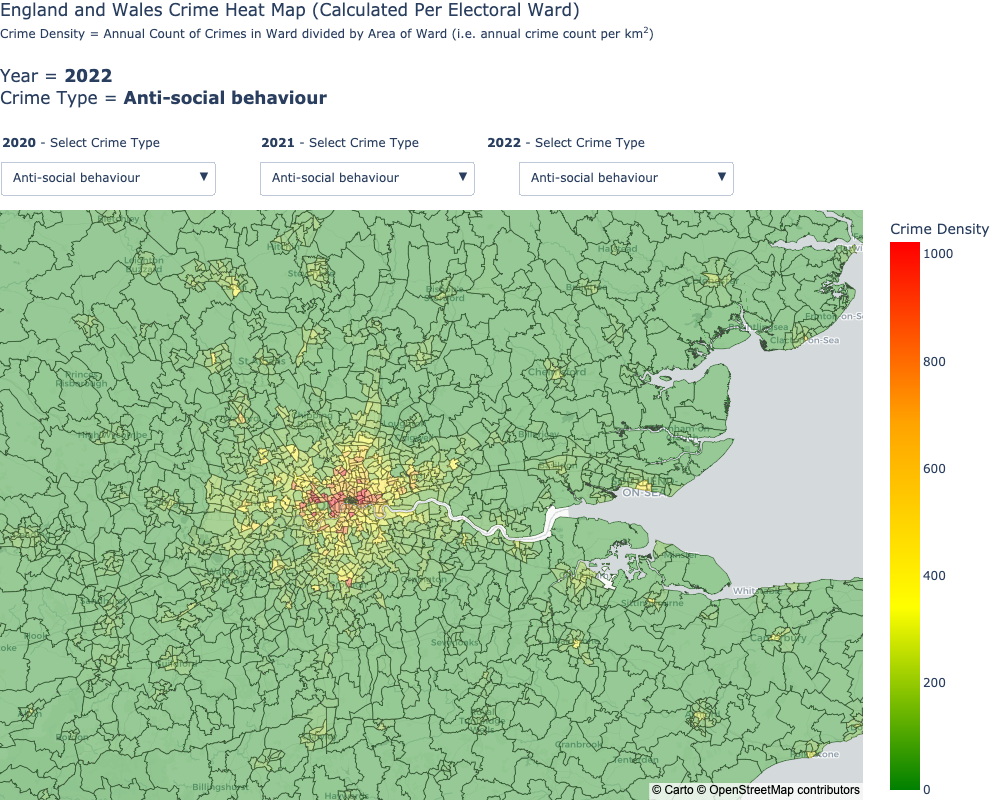

In [36]:
# Plot will default to 'Anti-social behaviour' (first item in crime_type)
crime_type = crime_types[0]
plot_data = plot_dfs[crime_type]['last year']

max_scale = outlier_limits[crime_type]

fig = px.choropleth_mapbox(plot_data, geojson=geojson, 
                           featureidkey="properties.id", 
                           locations = 'id',
                           hover_name = 'area_desc',
                           hover_data = ['crime_count'],
                           mapbox_style="carto-positron", 
                           color = 'crime_count_per_km2',
                           opacity = 0.4,
                           animation_frame = 'time_period',
                           title = "England and Wales Crime Heat Map (Calculated Per Electoral Ward)<br><span style=\"font-size: 12px;\">Crime Density = Annual Count of Crimes in Ward divided by Area of Ward (i.e. annual crime count per km<sup>2</sup>)</span><br><br>Year = <b>2022</b><br>Crime Type = <b>Anti-social behaviour</b>",
                           color_continuous_scale=['green', 'yellow', 
                                                   'orange', 'red'],
                           range_color=(0, max_scale),
                           center = {'lat':51.5072, 'lon':0.1276}, 
                           height = 800, width = 1000)

# Define and store coloraxis. This dictionary will need to be supplied
# for the drop down buttons to change the plotted data correctly 
coloraxis = {'colorbar': {'title': {'text': 'Crime Density'}},
             'colorscale': [[0.0, 'green'],
              [0.3333333333333333, 'yellow'],
              [0.6666666666666666, 'orange'],
              [1.0, 'red']],
             'cmin': 0,
             'cmax': 1009.5645805772134}

# Redefine the popup information displayed
hover_template = "<b>%{hovertext}</b><br><br>Crime Density = %{z}<br>crime count (for entire ward) = %{customdata[0]}<extra></extra>"
# We decided to rename the time periods to years to make the plot easier
# to understand. e.g. we will display the time period 'last year' as
# '2022' and 2 years ago as '2021' etc.   
years = ['2022', '2021', '2020']

# Define the Drop Down buttons for changing the crime type and time period
# being displayed by the plot.   
buttons = {}
for time_period, year in zip(time_periods, years):
    button_group = []
    for crime in crime_types: 
        data = plot_dfs[crime][time_period]
        z = [data.crime_count_per_km2]
        customdata = [[[crime_count] for crime_count in data.crime_count]]
        locations = [data.id]
        hover_text = [data.area_desc]
        coloraxis['cmax'] = outlier_limits[crime]
        args = [{'z': z, 'customdata': customdata, 
                 'locations': locations, 
                 'hovertext': hover_text}, 
                 {'coloraxis':coloraxis,
                 'title': {'text': f"England and Wales Crime Heat Map (Calculated Per Electoral Ward)<br><span style=\"font-size: 12px;\">Crime Density = Annual Count of Crimes in Ward divided by Area of Ward (i.e. annual crime count per km<sup>2</sup>)</span><br><br>Year = <b>{year}</b><br>Crime Type = <b>{crime}</b>", 
                           'y': 0.98, 'x':0}}
                 ]
        button = dict(args = args, label = crime,
                 method = 'update'            
            )
        button_group.append(button)
    buttons[time_period] = button_group 

# Add dropdown buttons (added 3 drop down buttons from left to right. Each
# defines a different time period of data. 
fig.update_layout(
    updatemenus=[
        dict(
            buttons=list(buttons[time_periods[2]]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
        dict(
            buttons=list(buttons[time_periods[1]]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.3,
            xanchor="left",
            y=1.1,
            yanchor="top"
        ),
        dict(
            buttons=list(buttons[time_periods[0]]),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=True,
            x=0.6,
            xanchor="left",
            y=1.1,
            yanchor="top",
        ),
        
    ]
)
# Manually fix max color scale for each crime type button (for 
# some reason the above code adds the colorbar changes to each 
# button but keeps the max scale the same for all of them). 
for index, crime in enumerate(crime_types):
    fig.layout.updatemenus[0].buttons[index].args[1]['coloraxis']['cmax'] = outlier_limits[crime]
    fig.layout.updatemenus[1].buttons[index].args[1]['coloraxis']['cmax'] = outlier_limits[crime]
    fig.layout.updatemenus[2].buttons[index].args[1]['coloraxis']['cmax'] = outlier_limits[crime]
# Add labels for drop down buttons 
fig.update_layout(
    annotations=[
        dict(text="<b>2020</b> - Select Crime Type", x=0, xref="paper",
             y=1.13, yref="paper", showarrow=False, align = 'center'),
        dict(text="<b>2021</b> - Select Crime Type", x=0.3, xref="paper", 
             y=1.13, yref="paper", showarrow=False, align = 'center'),
        dict(text="<b>2022</b> - Select Crime Type", x=0.75, xref="paper", 
             y=1.13, yref="paper", showarrow=False, align = 'right')
    ])    
    
fig.update_layout(margin={"r":0,"t":210,"l":0,"b":0}, title_y = 0.98,
                  title_x = 0, coloraxis_colorbar_title_text = 'Crime Density')
fig.update_traces(hovertemplate = hover_template)
fig.show(renderer="png")

In [ ]:
fig.write_html("plots/england_wales_crime_heatmap_choropleth.html")

### Observations
- Low and high crime areas are easy to spot
- We are able to represent all crime data across all of England and Wales in a single chart. 
- The map has high performance i.e. is not slow to load 
- Using the drop down buttons, we have access to viewing each crime type separately (or combined) and can easily switch between 3 different years of data
- The drop down buttons are confusing. Ideally, we would have just 2 drop downs. One would toggle the year and the other would toggle the crime type. Unfortunately, we don't think plotly can implement this, so settled for the more confusing buttons. 
- The level of precision is very variable and entirely dependent on the size of the electoral wards. In cities, especially london, we have relatively good precision. Outside cities, we have very large electoral wards which offer quite poor precision. More consistently sized and smaller boundaries (such as post codes) would probably improve the precision. 

## Crime Heatmap - Scatter Plot
We will now visualise the crime data using a scatter plot. A scatter plot will mark the position of every crime on a map. As such, it does not aggregate the crime data i.e. it uses the raw crime_data dataframe and every single crime recorded in it. This is a huge amount of data, almost 9 million crimes! Plotly is unable to plot all this data on a single map in a stable way - if you try it runs poorly and crashes. Therefore, we will just visualise London's crime data for 2022 (for the time period Aug-2021 - Jul-2022). 

### Define London Region
We need to filter the london crimes from the crime_data dataframe. We will do this by defining maximum and minimum latitude and longitude coordinates that defines the London region:  

In [37]:
max_lat = 51.602219
min_lat = 51.359634
min_lon = -0.320281
max_lon = 0.087431

### Add Size Column
Plotly requires a column to be used to set the size of each marker. We want each marker to have the same size. As such, we will create a new column in crime_data which has the size value we want for all rows: 

In [38]:
crime_data['size'] = 3

### Prepare Plotting Data
We want to include a drop down to select which crime type to view. As before, to help us do this, we will split the crime data according to the crime type and store each as a separate dataframe within a dictionary. 

Below we prepare this dictionary and filter the crime data according to the london region: 

In [39]:
# Get unique crime types
crime_types = crime_data['Crime type'].unique()

plot_dfs = {}

# Loop through crime types
for crime_type in crime_types:
    # Filter on the data for current crime_type and on last years data
    crime_type_df = crime_data[(crime_data['Crime type'] == crime_type) 
                                & (crime_data['time_period'] == 'last year')]
    # Filter data by london region (defined by lat and long max and min)
    crime_type_df = crime_type_df[(min_lon < crime_type_df.Longitude) 
                                  & (crime_type_df.Longitude < max_lon) 
                                  & (min_lat < crime_type_df.Latitude) 
                                  & (crime_type_df.Latitude < max_lat)]
    # Save data for plotting
    plot_dfs[crime_type] = crime_type_df
    
# Example of using nested dictionary to identify to plot
plot_dfs['Bicycle theft'].head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,time_period,geometry,size
2783777,7fe9e746802d6a2edda07721b40ca4687ecdcd49012fe8...,2021-09-01,Metropolitan Police Service,Metropolitan Police Service,0.080477,51.539024,On or near Supermarket,E01000007,Barking and Dagenham 015A,Bicycle theft,Investigation complete; no suspect identified,NaN,last year,POINT (0.08048 51.53902),3
2783819,55477bfecc6f4837a41640fe1236ccf412a07faf185092...,2021-09-01,Metropolitan Police Service,Metropolitan Police Service,0.072566,51.540108,On or near Cowbridge Lane,E01000008,Barking and Dagenham 015B,Bicycle theft,Investigation complete; no suspect identified,NaN,last year,POINT (0.07257 51.54011),3
2783869,a5248d2c607f4d7d959fc7f92d13d82a0e3bcbaabf6419...,2021-09-01,Metropolitan Police Service,Metropolitan Police Service,0.080758,51.538848,On or near Station Parade,E01000010,Barking and Dagenham 015C,Bicycle theft,Investigation complete; no suspect identified,NaN,last year,POINT (0.08076 51.53885),3
2783870,c5a8ce4c718ec0f5feba143b3d219fb3d39b2faf00ea97...,2021-09-01,Metropolitan Police Service,Metropolitan Police Service,0.077044,51.537106,On or near Parking Area,E01000010,Barking and Dagenham 015C,Bicycle theft,Investigation complete; no suspect identified,NaN,last year,POINT (0.07704 51.53711),3
2784032,0a70a2a2eafa67270827c6ebeecd658a056f66f6e0c845...,2021-09-01,Metropolitan Police Service,Metropolitan Police Service,0.082183,51.543229,On or near Park Avenue,E01000011,Barking and Dagenham 016C,Bicycle theft,Investigation complete; no suspect identified,NaN,last year,POINT (0.08218 51.54323),3


### Plotting Scatter Map
Below we plot the 2022 crime data for the London region as a scatter plot.

Notes: 
- A drop down allows you to select different crime types to view. We ran out of time and so did not include an 'all crimes' crime type option. 
- We made each crime marker a transparent circle. When crime markers overlap, they become less transparent. Darker regions indicate more crimes. 

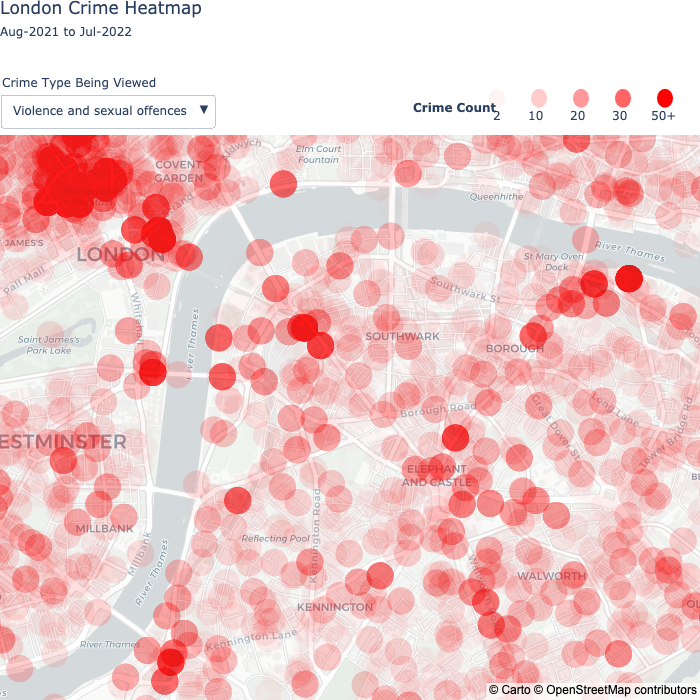

In [40]:
# Select intial crime type to be viewed
plot_data = plot_dfs['Violence and sexual offences']

# Create basic map scatter plot
fig2 = px.scatter_mapbox(plot_data, 
                         title = 'London Crime Heatmap <br><span style=\"font-size: 12px;\">Aug-2021 to Jul-2022</span>', 
                         lat="Latitude", lon="Longitude",
                         color_discrete_sequence=['red'], zoom=13,
                         size = 'size',
                         mapbox_style = 'carto-positron', 
                         opacity = 0.02, height = 700)

# Template dictionary to define marker attribute of plot for each drop
# down button
marker = {'color': 'red',
          'opacity': 0.02,
          'sizemode': 'area',
          'sizeref': 0.01}

buttons = []
# Create button for each crime type
for crime_type in crime_types:
    # Select crime type data
    data = plot_dfs[crime_type]
    # Define lat and long data for selected crime type
    lat = [data.Latitude]
    lon = [data.Longitude]
    # Define marker size data
    marker['size'] = data['size'].values
    # Define button arguments (define how plot attributes are changed on
    # button press)
    args = [{'lat':lat, 'lon':lon, 'marker':marker}]
    # Create button
    button = dict(args = args, label = crime_type, method = 'restyle')
    buttons.append(button)

# Add dropdown consisting of the buttons defined above
fig2.update_layout(
    updatemenus=[
        dict(
            buttons=list(buttons),
            direction="down",
            pad={"r": 10, "t": 10},
            showactive=False,
            x=0,
            xanchor="left",
            y=1.09,
            yanchor="top"
        ),
    ]
)

# Make the Button show the initial data as Violence and sexual Offenses (by
# default, the button will indicate the first item in the dropdown which is 
# not Violence and sexual crimes, even though that data will be shown initially)
current_button = crime_types.tolist().index('Violence and sexual offences')
fig2.layout.updatemenus[0]['active'] = current_button

# Update hovertemplate to be blank (don't shopw data on mouse popup) - this 
# will default the pop up to show the lat long coordinates. 
fig2.update_traces(hovertemplate = '')

# Manually fix the size values for each button in the dropdown (for some 
# reason it wasnt set correctly when making the buttons above)
#for index, crime in enumerate(crime_types):
#    data = plot_dfs[crime]
#    fig2.layout.updatemenus[0].buttons[index]['args'][0]['marker']['size'] = data['size'].values
    
# Update margins and title positioning    
fig2.update_layout(margin={"r":0,"t":135,"l":0,"b":0}, title_x = 0, title_y = 0.98)

# 
fig2.update_layout(
    annotations=[
        dict(text = "Crime Type Being Viewed", x = 0, xref= "paper", y = 1.11, 
             yref = "paper", showarrow = False, align = 'left')  
    ])   

# Build color key
key_size = 0.02
y_min = 1.05
y_max = 1.08

# define start position of key
x_pos = 0.7

# Add key title
fig2.add_annotation(text = "<b>Crime Count</b>", x = x_pos - 0.05, xref= "paper", 
             y = 1.065, yref = "paper", showarrow = False, align = 'left')

# Define key contents (dictionary with opacity and number of crime)
plot_key = {0.04:'2', 0.2:'10', 0.4: '20', 0.6:'30', 1:'50+'}

# Add circle shape and text for each opacity and number of crimes combination
for opacity, no_crimes in plot_key.items():
    fig2.add_shape(type = "circle", xref = "paper", yref = "paper",x0 = x_pos, 
               y0 = y_min, x1 = x_pos + key_size, y1 = y_max, opacity = opacity,
               fillcolor = "red", line_color = "red"
    )
    
    x_mid = (x_pos + x_pos + key_size)/2
    fig2.add_annotation(text = f"{no_crimes}", x = x_mid + 0.008, xref= "paper", 
             y = 1.052, yref = "paper", showarrow = False, align = 'center')
    # iterate position of shape and text
    x_pos = x_pos + 3*key_size

# Manually fix x positions of last 2 items in key
fig2.layout.annotations[-1].x = 0.9689
fig2.layout.annotations[-2].x = 0.899
fig2.show(renderer="png")

### Observations: 
- Provides very granular detail of the volume of crime in different areas. The exact locations of crimes are shown and large areas are not aggregated together (which tends to generalise the crime counts and thus potentially make low crime locations look dangerous because they were aggregated with a high crime area).  
- Harder plot to understand, it is not immediately intuitive.  
- The map has been calibrated for the default zoom level of the plot. Zooming out tends to wash out the detail and make everything dark red i.e. high crime. The plot cannot easily be zoomed out for a high level perspective.
- Harder to get specific crime figures i.e. the darkness of the red (the transparency) is hard to match to the key to understand the exact number of crimes committed in an area. Also, the key does not go above 50 crimes i.e. areas with over 50 crimes cannot be differentiated from areas with 50 crimes.
- Only shows crime in a small region (in this case London)
- This plot has kept complexity, and therefore precision but is harder to use if you want a snapshot that is quick and easy to digest. 

In [41]:
fig2.write_html("plots/London_Crime_Heatmap_Scatter.html")

## Crime Heatmap - Hex Bin
### Plotting London Crime Hexbin
Below we will build a hex bin map to visualise violent crime in the London area, using data from between August 2021 and July 2022. The hex bin will split the area into equal size hexagons which will be colored according to the number of crimes committed within each hexagon. We will only visualise violent crime and only use a single year of data because we are running low on time. 

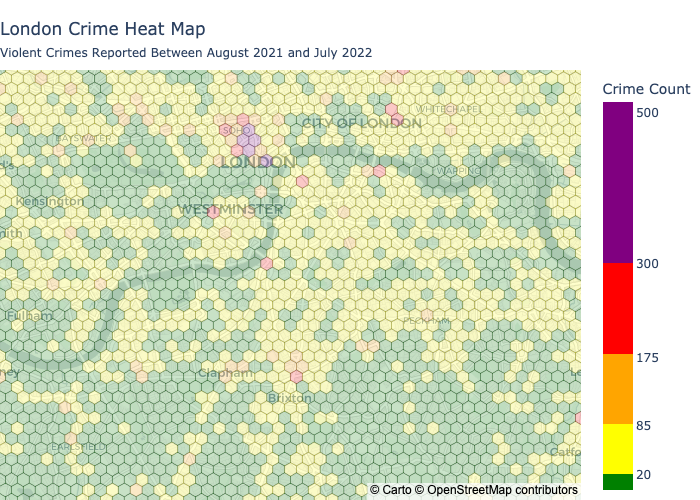

In [42]:
# Create hex bin plot
fig4 = ff.create_hexbin_mapbox(data_frame = plot_data, lat = "Latitude", 
                               lon = "Longitude", nx_hexagon = 100, 
                               opacity = 0.2, mapbox_style = 'carto-positron',
                               title = 'London Crime Heat Map <br><span style=\"font-size: 12px;\">Violent Crimes Reported Between August 2021 and July 2022</span>',
                               zoom = 11, 
                               color_continuous_scale = [
                                   (0, 'green'), (0.04, 'green'), 
                                   (0.04, 'yellow'), (0.17, 'yellow'), 
                                   (0.17, 'orange'), (0.35, 'orange'), 
                                   (0.35, 'red'), (0.584,'red'), 
                                   (0.584,'purple'), (1,'purple')]
                              )
# Update margins and move titel position
fig4.update_layout(margin = dict(b = 0, t = 70, l = 0, r = 0), title_x = 0)

# Add color bar tick labels  
fig4.update_layout(coloraxis_colorbar = dict(title="Crime Count",
                                             tickvals=[20,85,175,300, 500],
                                             ticktext=["20", "85", "175",'300', "500"])
                  )
# Update popup data to show crime count only
fig4.update_traces(hovertemplate = 'Crime Count = %{z}<extra></extra>')

fig4.show(renderer="png")

**Observations:**
- The equal areas of the hexagons makes this plot very easy to understand (i.e. simply the number of crimes that occurred within each hexagon). It is also possible to get the exact number of crimes per hexagon by hovering the mouse over. 
- This plot allows us to see the logarithmic dynamics of the crime count i.e. high crime areas have orders of magnitude more crime than lower crime areas, and we can easily see and appreciate this.
- The plot has high granularity - the hexagons enclose relatively small areas and so we get a relatively high resolution picture of where crimes tend to occur, and where they don't. 
- This is our favourite plot, we think it is a good tradeoff between high granularity (i.e. can see more precisely where crime is and is not happening) whilst remaining easy and intuitive to interpret.
- The colorbar does not have the same opacity as the polygons, which may be slightly confusing. We tried to fix this but found it quite tricky. 
- A legend that specified the range of each colour would have been a better way to represent the meaning of the colours. Again, this was surprisingly difficult to fix and was not worth the time so we kept the colorbar.  
- The map is using a Mercator projection - this is not an equal area projection and thus while the polygons have equal area using the projected coordinates, they are probably warped in reality and thus not actually all the same size. This could be fixed by changing to an equal area projection. 
- Adding drop downs to change the crime type being viewed and the year of the data would make the map more useful.  

In [ ]:
fig4.write_html("plots/london_crime_heat_map_hex_bin.html")

### Plotting England, Wales and Ireland Crime Hexbin
Below, we will create our final plot. This will extend the hexbin map beyond London to visualise all Violent and sexual crimes from Aug-2021 to July-2022 within England, Wales and Northern Ireland. We will adjust the number of hexbins such that the area per hexagon will be larger than in the above map - this will make it less precise but easier to render for such a large area of land. 

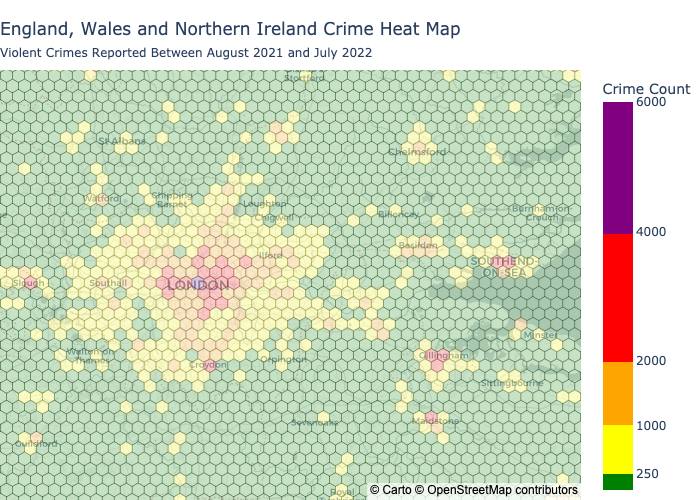

In [43]:
# Select all violent crimes from last year
crime_data_selected = crime_data[
    (crime_data['Crime type'] == 'Violence and sexual offences') 
    & (crime_data['time_period'] == 'last year')]
# Create hex bin plot
fig5 = ff.create_hexbin_mapbox(
    data_frame = crime_data_selected, lat = "Latitude", lon = "Longitude",
    nx_hexagon = 300, opacity = 0.2, mapbox_style = 'carto-positron',
    title = 'England, Wales and Northern Ireland Crime Heat Map <br><span style=\"font-size: 12px;\">Violent Crimes Reported Between August 2021 and July 2022</span>',
    zoom = 8, range_color = (0,6000), center = {'lat':51.5072, 'lon':0.1246},
    color_continuous_scale = [(0,'green'),(0.042, 'green'), 
                              (0.042, 'yellow'), (0.167, 'yellow'), 
                              (0.167, 'orange'), (0.33, 'orange'), 
                              (0.33, 'red'), (0.66,'red'), 
                              (0.66,'purple'), (1,'purple')]
)
# fix margins and title position
fig5.update_layout(margin=dict(b=0, t=70, l=0, r=70), title_x = 0)
# Add colorbar tick labels
fig5.update_layout(coloraxis_colorbar=dict(
    title="Crime Count",
    tickvals=[250,1000,2000,4000, 6000],
    ticktext=["250", "1000", "2000",'4000', "6000"],
))
# Update popup to show crime count only
fig5.update_traces(hovertemplate = 'Crime Count = %{z}<extra></extra>')

fig5.show(renderer="png")

In [ ]:
fig5.write_html("plots/england_wales_ireland_crime_heat_map_hex_bin.html")